# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.6 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
def load_json_dataframe(filepath):
    try:
        df = pd.read_json(filepath)
        return df
    except ValueError as e:
        print("Error reading the JSON file:", e)
        return None

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
df = load_json_dataframe("ingredient_and_quantity.json")

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
df.head()

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [8]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [9]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())
# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [11]:
# display first five rows of the dataframe - df
df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [13]:
# check for the equality of input_length and pos_length in the dataframe
df['lengths_equal'] = df['input_length'] == df['pos_length']

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [14]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    all_labels = [label for row in df['pos_tokens'] for label in row]
    unique = sorted(set(all_labels))
    print("Unique POS labels:", unique)
    return unique

In [15]:
unique_pos_tags = unique_labels(df)

Unique POS labels: ['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


To identify indexes that require cleaning and formatting in your DataFrame (let’s call it `df`), you typically check for issues like:

- Missing values  
- Empty or malformed tokens  
- Mismatched `input_length` and `pos_length`  
- Unexpected data types

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [16]:
# drop the irrelevant recipe data

# Drop rows with null values in input or pos
df = df.dropna(subset=['input', 'pos'])

# Drop rows where input_tokens or pos_tokens are empty
df = df[df['input_tokens'].apply(lambda x: len(x) > 0)]
df = df[df['pos_tokens'].apply(lambda x: len(x) > 0)]

# Drop rows where token lengths don't match
df = df[df['input_length'] == df['pos_length']]

In [17]:
df.shape

(280, 7)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [18]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [19]:
df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,lengths_equal
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient q

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [20]:
# validate the input length and pos length as input_length and pos_length
input_length_check = (df['input_length'] == df['input_tokens'].apply(len)).all()
pos_length_check = (df['pos_length'] == df['pos_tokens'].apply(len)).all()
print(f"Input Length Valid: {input_length_check}")
print(f"POS Length Valid: {pos_length_check}")

Input Length Valid: True
POS Length Valid: True


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [21]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [22]:
# print the first five rows of train_df
train_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,lengths_equal
89,1/2 cup Sooji Semolina Rava teaspoon Ghee 3 cups Milk 3/4 Sugar 5 Saffron strands 1 Cardamom Elaichi Pods Seeds Cashew nuts Raisins Mixed dry fruits chopped,quantity unit ingredient ingredient ingredient unit ingredient quantity unit ingredient quantity ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1/2, cup, Sooji, Semolina, Rava, teaspoon, Ghee, 3, cups, Milk, 3/4, Sugar, 5, Saffron, strands, 1, Cardamom, Elaichi, Pods, Seeds, Cashew, nuts, Raisins, Mixed, dry, fruits, chopped]","[quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",27,27,True
140,50 grams Wheat Grass Powder 1/2 teaspoon Black pepper powder 1 Cumin Jeera Lemon juiced,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient,"[50, grams, Wheat, Grass, Powder, 1/2, teaspoon, Black, pepper, powder, 1, Cumin, Jeera, Lemon, juiced]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient]",15,15,True
188,2 cups Potatoes Aloo 1 Tomatoes finely chopped 1-1/2 tablespoon Ginger grated ground Green Chillies slit tablespoons Kasuri Methi Dried Fenugreek Leaves 1/2 teaspoon Fennel seeds Saunf Cumin Jeera Seeds Coriander Powder Dhania Red Chilli powder Turmeric Haldi Garam masala teaspoons Amchur Dry Mango Ghee Salt to taste,quantity unit ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[2, cups, Potatoes, Aloo, 1, Tomatoes, finely, chopped, 1-1/2, tablespoon, Ginger, grated, ground, Green, Chillies, slit, tablespoons, Kasuri, Methi, Dried, Fenugreek, Leaves, 1/2, teaspoon, Fennel, seeds, Saunf, Cumin, Jeera, Seeds, Coriander, Powder, Dhania, Red, Chilli, powder, Turmeric, Haldi, Garam, masala, teaspoons, Amchur, Dry, Mango, Ghee, Salt, to, taste]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",48,48,True
5,1 cup Rice 1/2 Yellow Moong Dal Mint Leaves 1/4 Coriander Dhania Green Chilli inch Ginger teaspoon Cumin seeds 5 cups Water Sunflower Oil Salt 2 tablespoons Ghee 8 Cashew nuts halved Whole Black Peppercorns sprig Curry leaves pinch Asafoetida hing,quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient unit ingredient ingredient,"[1, cup, Rice, 1/2, Yellow, Moong, Dal, Mint, Leaves, 1/4, Coriander, Dhania, Green, Chilli, inch

In [23]:
# print the first five rows of the val_df
val_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,lengths_equal
35,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15,True
111,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56,True
245,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35,True
264,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ing

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [24]:
# extract the training and validation sets by taking input_tokens and pos_tokens
# Extract training sets
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

# Extract validation sets
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [25]:
# validate the shape of training and validation samples
print("Training Set - X_train:", len(X_train), ", y_train:", len(y_train))
print("Validation Set - X_val:", len(X_val), ", y_val:", len(y_val))

Training Set - X_train: 224 , y_train: 224
Validation Set - X_val: 56 , y_val: 56


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [26]:
# Display the number of unique labels present in y_train
flat_labels = [label for sentence in y_train for label in sentence]
unique_labels = set(flat_labels)
print("Number of unique labels in y_train:", len(unique_labels))
print("Unique labels:", unique_labels)

Number of unique labels in y_train: 3
Unique labels: {'quantity', 'unit', 'ingredient'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [27]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list, dataset_name='Training'):
    flat_list = [token for sublist in nested_list for token in sublist]
    print(f"Total tokens in {dataset_name} dataset after flattening: {len(flat_list)}")
    return flat_list

In [28]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [29]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    # Flatten input_tokens and pos_tokens
    flat_input_tokens = flatten_list(df['input_tokens'].tolist(), dataset_name)
    flat_pos_tokens = flatten_list(df['pos_tokens'].tolist(), dataset_name)

    # Validate lengths
    if len(flat_input_tokens) != len(flat_pos_tokens):
        print(f"Mismatch in lengths for {dataset_name} dataset:")
        print(f"input_tokens: {len(flat_input_tokens)}")
        print(f"pos_tokens: {len(flat_pos_tokens)}")
    else:
        print(f"[{dataset_name}] Lengths Match: {len(flat_input_tokens)} tokens")

    # Display first 10 tokens
    print(f"\nFirst 10 input tokens in {dataset_name}:")
    print(flat_input_tokens[:10])

    print(f"\nFirst 10 POS tokens in {dataset_name}:")
    print(flat_pos_tokens[:10])

In [30]:
# extract the tokens and its pos tags
flat_input_tokens_train = flatten_list(train_df['input_tokens'].tolist(), 'Training')
flat_pos_tokens_train = flatten_list(train_df['pos_tokens'].tolist(), 'Training')
token_pos_pairs_train = list(zip(flat_input_tokens_train, flat_pos_tokens_train))
for token, pos in token_pos_pairs_train:
    print(f"{token} --> {pos}")

Total tokens in Training dataset after flattening: 8008
Total tokens in Training dataset after flattening: 8008
1/2 --> quantity
cup --> unit
Sooji --> ingredient
Semolina --> ingredient
Rava --> ingredient
teaspoon --> unit
Ghee --> ingredient
3 --> quantity
cups --> unit
Milk --> ingredient
3/4 --> quantity
Sugar --> ingredient
5 --> quantity
Saffron --> ingredient
strands --> ingredient
1 --> quantity
Cardamom --> ingredient
Elaichi --> ingredient
Pods --> ingredient
Seeds --> ingredient
Cashew --> ingredient
nuts --> ingredient
Raisins --> ingredient
Mixed --> ingredient
dry --> ingredient
fruits --> ingredient
chopped --> ingredient
50 --> quantity
grams --> unit
Wheat --> ingredient
Grass --> ingredient
Powder --> ingredient
1/2 --> quantity
teaspoon --> unit
Black --> ingredient
pepper --> ingredient
powder --> ingredient
1 --> quantity
Cumin --> ingredient
Jeera --> ingredient
Lemon --> ingredient
juiced --> ingredient
2 --> quantity
cups --> unit
Potatoes --> ingredient
Aloo -

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [31]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):

    # Ensure lengths match
    if len(tokens) != len(pos_tags):
        print("Mismatch in token and POS tag lengths.")
        return [], [], []

    # Initialize result lists
    ingredients = []
    units = []
    quantities = []
    for token, tag in zip(tokens, pos_tags):
        token_lower = token.lower()

        # Check if token is numeric or fraction -> quantity
        if tag == 'CD' or token_lower.isdigit() or any(c in token_lower for c in ['/', '.', '½', '¼']):
            quantities.append(token)

        # Check for common unit indicators
        elif token_lower in ['cup', 'cups', 'tbsp', 'tablespoon', 'tablespoons', 'tsp', 'teaspoon', 'teaspoons', 'ml', 'grams', 'g', 'kg', 'l', 'oz']:
            units.append(token)

        # Otherwise, treat as ingredient (based on NOUN or other heuristics)
        else:
            ingredients.append(token)

    return ingredients, units, quantities



In [32]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(flat_input_tokens_train, flat_pos_tokens_train)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [33]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name):
    counter = Counter(item_list)
    top_items = counter.most_common(10)

    print(f"\nTop 10 {pos_label}s in the {dataset_name} Dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items


In [34]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, pos_label="Ingredient", dataset_name="Training")


Top 10 Ingredients in the Training Dataset:
powder: 148
Salt: 116
seeds: 103
chopped: 94
Oil: 94
Red: 93
Green: 91
Chilli: 89
Coriander: 82
Sunflower: 75


In [35]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, pos_label="Unit", dataset_name="Training")


Top 10 Units in the Training Dataset:
teaspoon: 182
cup: 149
tablespoon: 109
grams: 75
tablespoons: 70
cups: 56
teaspoons: 45
tsp: 13
tbsp: 5
Teaspoon: 3


In [36]:
ingredients

['Sooji',
 'Semolina',
 'Rava',
 'Ghee',
 'Milk',
 'Sugar',
 'Saffron',
 'strands',
 'Cardamom',
 'Elaichi',
 'Pods',
 'Seeds',
 'Cashew',
 'nuts',
 'Raisins',
 'Mixed',
 'dry',
 'fruits',
 'chopped',
 'Wheat',
 'Grass',
 'Powder',
 'Black',
 'pepper',
 'powder',
 'Cumin',
 'Jeera',
 'Lemon',
 'juiced',
 'Potatoes',
 'Aloo',
 'Tomatoes',
 'finely',
 'chopped',
 'Ginger',
 'grated',
 'ground',
 'Green',
 'Chillies',
 'slit',
 'Kasuri',
 'Methi',
 'Dried',
 'Fenugreek',
 'Leaves',
 'Fennel',
 'seeds',
 'Saunf',
 'Cumin',
 'Jeera',
 'Seeds',
 'Coriander',
 'Powder',
 'Dhania',
 'Red',
 'Chilli',
 'powder',
 'Turmeric',
 'Haldi',
 'Garam',
 'masala',
 'Amchur',
 'Dry',
 'Mango',
 'Ghee',
 'Salt',
 'to',
 'taste',
 'Rice',
 'Yellow',
 'Moong',
 'Dal',
 'Mint',
 'Leaves',
 'Coriander',
 'Dhania',
 'Green',
 'Chilli',
 'inch',
 'Ginger',
 'Cumin',
 'seeds',
 'Water',
 'Sunflower',
 'Oil',
 'Salt',
 'Ghee',
 'Cashew',
 'nuts',
 'halved',
 'Whole',
 'Black',
 'Peppercorns',
 'sprig',
 'Curry',


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [37]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt

def plot_top_items(top_item_list, label, dataset_name):
    if not top_item_list:
        print(f"No top {label}s to plot in {dataset_name} dataset.")
        return

    # Split the items and their counts
    items, counts = zip(*top_item_list)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts)
    plt.title(f"Top 10 {label}s in {dataset_name} Dataset")
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



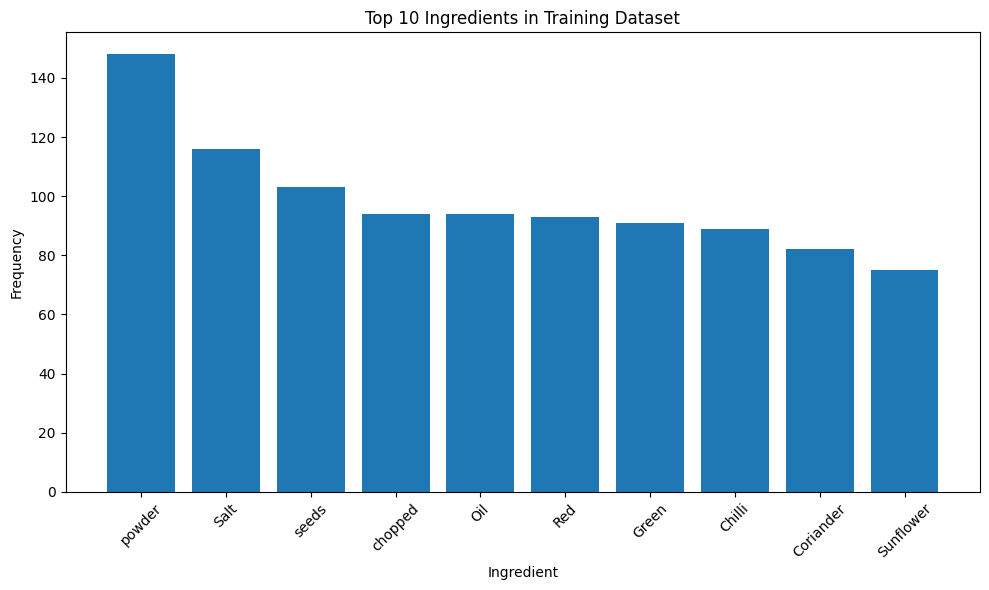

In [38]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, label="Ingredient", dataset_name="Training")

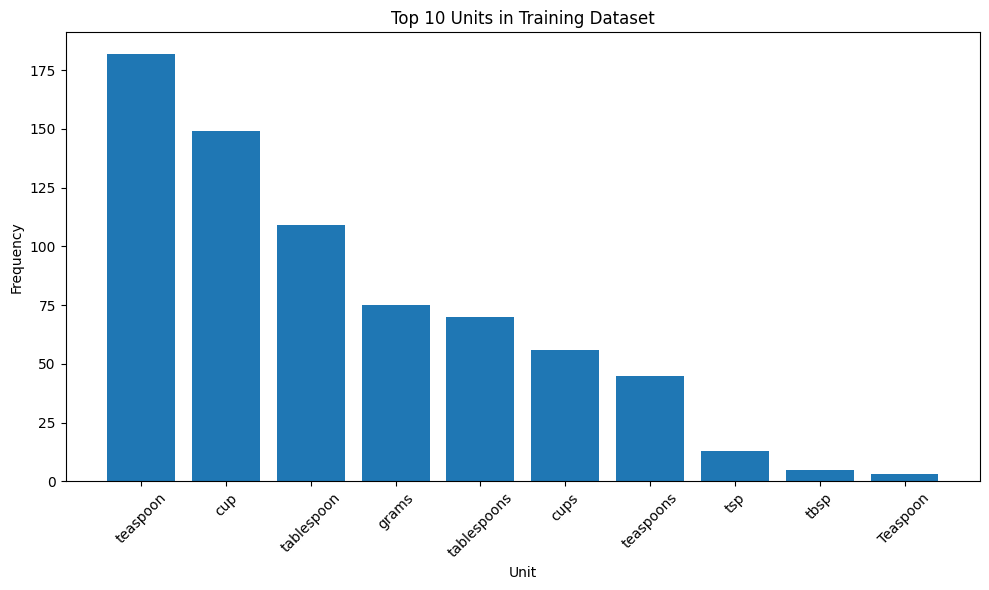

In [39]:
# plot the top frequent units in training data
plot_top_items(top_units, label="Unit", dataset_name="Training")

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [40]:
# initialise the dataset_name


In [41]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [42]:
# plot the top frequent ingredients in validation data


In [43]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [44]:
# define unit and quantity keywords along with quantity pattern
# Define unit-related keywords
unit_keywords = {
    'cup', 'cups', 'tbsp', 'tablespoon', 'tablespoons', 'tsp', 'teaspoon', 'teaspoons',
    'ounce', 'ounces', 'oz', 'pound', 'pounds', 'lb', 'lbs', 'gram', 'grams', 'g',
    'kilogram', 'kilograms', 'kg', 'ml', 'milliliter', 'milliliters', 'liter', 'liters', 'l',
    'pinch', 'dash', 'clove', 'cloves', 'can', 'cans', 'slice', 'slices', 'stick', 'sticks'
}

quantity_keywords = {
    'half', 'quarter', 'third', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',
    'eight', 'nine', 'ten', 'eleven', 'twelve'
}

# Regex pattern for capturing fractions, numbers, and decimals (e.g., 1/2, 1.5, 3)
quantity_pattern = re.compile(r'^\d+(\.\d+)?$|^\d+/\d+$|^\d+\s\d+/\d+$')

In [45]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [46]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
def word2features(sent, i):
    token = sent[i]
    text = token.text
    lower_text = text.lower()

    # --- Core Features ---
    features = {
        'bias': 1.0,
        'token': lower_text,
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': text.isdigit(),
        'has_digit': any(char.isdigit() for char in text),
        'has_alpha': any(char.isalpha() for char in text),
        'hyphenated': '-' in text,
        'slash_present': '/' in text,
        'is_title': text.istitle(),
        'is_upper': text.isupper(),
        'is_punct': token.is_punct,
    }

    # --- Improved Quantity & Unit Detection ---
    features.update({
        'is_quantity': lower_text in quantity_keywords or bool(quantity_pattern.match(text)),
        'is_unit': lower_text in unit_keywords,
        'is_numeric': bool(re.fullmatch(r'\d+', text)),
        'is_fraction': bool(re.fullmatch(r'\d+/\d+', text)),
        'is_decimal': bool(re.fullmatch(r'\d+\.\d+', text)),
        'preceding_word': sent[i - 1].text.lower() if i > 0 else '',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else '',
    })

    # --- Contextual Features ---
    if i > 0:
        prev_token = sent[i - 1]
        prev_text = prev_token.text.lower()
        features.update({
            'prev_token': prev_text,
            'prev_is_quantity': prev_text in quantity_keywords or bool(quantity_pattern.match(prev_token.text)),
            'prev_is_digit': prev_token.text.isdigit(),
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    if i < len(sent) - 1:
        next_token = sent[i + 1]
        next_text = next_token.text.lower()
        features.update({
            'next_token': next_text,
            'next_is_unit': next_text in unit_keywords,
            'next_is_ingredient': next_text not in unit_keywords and next_text not in quantity_keywords,
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [47]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [48]:
def tokenize_sentences(sentences):
    return [nlp(" ".join(tokens)) for tokens in sentences]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [49]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_docs = [nlp(" ".join(recipe)) for recipe in X_train]
X_val_docs = [nlp(" ".join(recipe)) for recipe in X_val]
X_train_features = [sent2features(doc) for doc in X_train_docs]
X_val_features = [sent2features(doc) for doc in X_val_docs]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [50]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [list(labels) for labels in y_train]
y_val_labels = [list(labels) for labels in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [51]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

Length of X_train_features: 224
Length of y_train_labels: 224


In [52]:
# print the length of validation features and labels
print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 56
Length of y_val_labels: 56


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [53]:
# Flatten labels in y_train
flat_y_train = [label for recipe in y_train_labels for label in recipe]

# Optionally, check the length
print("Total number of labels in flattened y_train:", len(flat_y_train))

Total number of labels in flattened y_train: 8008


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [54]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(flat_y_train)

# Calculate total number of samples
total_samples = sum(label_counts.values())

# Print the results
print("Label Frequencies:", label_counts)
print("Total Samples:", total_samples)

Label Frequencies: Counter({'ingredient': 5978, 'quantity': 1101, 'unit': 929})
Total Samples: 8008


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [55]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
num_classes = len(label_counts)

# Compute class weights using inverse frequency method
class_weights = {
    label: total_samples / (num_classes * count)
    for label, count in label_counts.items()
}

# Print class weights
print("Class Weights:", class_weights)

Class Weights: {'quantity': 2.4244626097487134, 'unit': 2.873340509508432, 'ingredient': 0.4465261514441842}


In [56]:
# penalise ingredient label
penalize_factor = 0.5

if 'ingredient' in class_weights:
    class_weights['ingredient'] *= penalize_factor

print("Updated Class Weights with Penalized 'ingredient':", class_weights)

Updated Class Weights with Penalized 'ingredient': {'quantity': 2.4244626097487134, 'unit': 2.873340509508432, 'ingredient': 0.2232630757220921}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [57]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    features = []
    labels = []
    sample_weights = []

    for sentence, label_seq in zip(X, y):
        sentence_features = sent2features(sentence)
        if len(sentence_features) != len(label_seq):
            print("Feature-label mismatch detected. Skipping this sample.")
            continue  # or fix manually

        features.append(sentence_features)
        labels.append(label_seq)

        # Weight per token based on label
        weights = [weight_dict.get(label, 1.0) for label in label_seq]
        sample_weights.append(weights)

    return features, labels, sample_weights

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [58]:
# Apply manually computed class weights
X_train_tokenized = tokenize_sentences(X_train)
X_val_tokenized = tokenize_sentences(X_val)
X_train_weighted_features, y_train_weighted_labels, train_sample_weights = extract_features_with_class_weights(
    X_train_tokenized, y_train, class_weights
)

# Apply the function to validation dataset
X_val_weighted_features, y_val_weighted_labels, val_sample_weights = extract_features_with_class_weights(
    X_val_tokenized, y_val, class_weights
)

Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-label mismatch detected. Skipping this sample.
Feature-la

In [59]:
len(X_train_weighted_features)

171

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [60]:
# initialise CRF model with the specified hyperparameters and use weight_dict
import sklearn_crfsuite

# Step 1: Initialize CRF model with specified hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',                # Optimization algorithm
    c1=0.5,                           # L1 regularization
    c2=1.0,                           # L2 regularization
    max_iterations=100,              # Maximum training iterations
    all_possible_transitions=True    # Add transitions that are not observed
)
# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_weighted_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [61]:
# evaluate on the training dataset
from sklearn_crfsuite import metrics

y_train_pred = crf.predict(X_train_weighted_features)


labels = list(crf.classes_)
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))

train_classification_report = metrics.flat_classification_report(
    y_train_weighted_labels, y_train_pred, labels=sorted_labels, digits=4
)

print("CRF Training Set Evaluation:\n")
print(train_classification_report)


CRF Training Set Evaluation:

              precision    recall  f1-score   support

  ingredient     0.9914    0.9970    0.9942      4264
        unit     0.9776    0.9660    0.9718       677
    quantity     1.0000    0.9798    0.9898       791

    accuracy                         0.9909      5732
   macro avg     0.9896    0.9809    0.9852      5732
weighted avg     0.9909    0.9909    0.9909      5732



In [62]:
# specify the flat classification report by using training data for evaluation
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
train_accuracy = accuracy_score(
    [label for sent in y_train_weighted_labels for label in sent],
    [label for sent in y_train_pred for label in sent]
)
print(f"Token-level Accuracy: {train_accuracy:.4f}")

Token-level Accuracy: 0.9909


<Figure size 1200x1000 with 0 Axes>

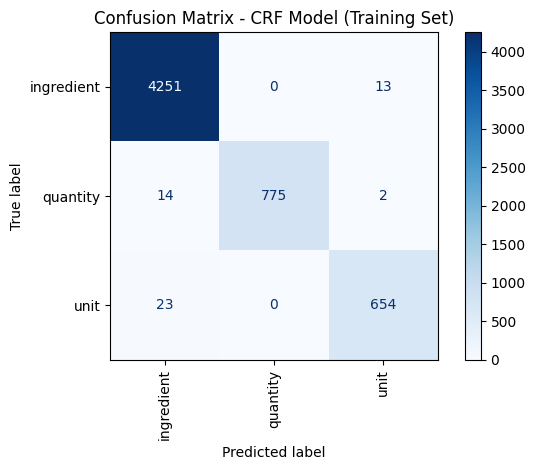

In [63]:
# create a confusion matrix on training datset
y_true_flat = [label for sent in y_train_weighted_labels for label in sent]
y_pred_flat = [label for seq in y_train_pred for label in seq]

# Get all unique labels from the model
labels = sorted(crf.classes_)

# Generate confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# Display the confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(include_values=True, xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix - CRF Model (Training Set)")
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [64]:
# dump the model using joblib as crf_model.pkl
import joblib

# Save the CRF model to a file
joblib.dump(crf, 'crf_model.pkl')

print("CRF model saved as crf_model.pkl")

CRF model saved as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [65]:
# predict the crf model on validation dataset
y_val_pred = crf.predict(X_val_weighted_features)

In [66]:
# specify flat classification report
print(flat_classification_report(y_val_weighted_labels, y_val_pred, digits=3))

              precision    recall  f1-score   support

  ingredient      0.986     0.997     0.991       758
    quantity      1.000     0.975     0.987       161
        unit      0.984     0.946     0.965       130

    accuracy                          0.988      1049
   macro avg      0.990     0.973     0.981      1049
weighted avg      0.988     0.988     0.988      1049



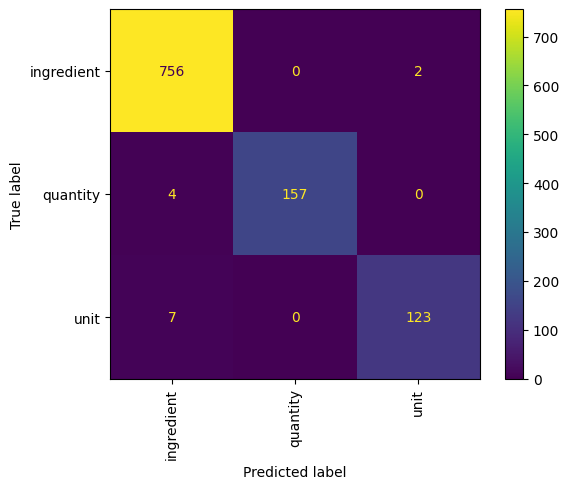

In [67]:
# create a confusion matrix on validation dataset
from sklearn_crfsuite.utils import flatten
y_val_true_flat = flatten(y_val_weighted_labels)
y_val_pred_flat = flatten(y_val_pred)

# Create the confusion matrix
labels = sorted(list(set(y_val_true_flat)))  # ensure consistent label ordering
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical')

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [68]:
# flatten Labels and Initialise Error Data
y_val_true_flat = flatten(y_val_weighted_labels)
y_val_pred_flat = flatten(y_val_pred)

# Initialise error data list
error_data = []

# Fill error_data with misclassified samples
for true_label, pred_label, sent in zip(y_val_weighted_labels, y_val_pred, X_val):
    for token, gold, pred in zip(sent, true_label, pred_label):
        if gold != pred:
            error_data.append({
                'token': token if isinstance(token, str) else token.text,
                'true_label': gold,
                'predicted_label': pred
            })

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [69]:
# iterate and collect Error Information
# get previous and next tokens with handling for boundary cases
error_info = []

for sent_idx, (tokens, gold_labels, pred_labels) in enumerate(zip(X_val, y_val_weighted_labels, y_val_pred)):
    for token_idx, (token, true_label, pred_label) in enumerate(zip(tokens, gold_labels, pred_labels)):
        if true_label != pred_label:

            token_text = token if isinstance(token, str) else token.text


            prev_token = tokens[token_idx - 1]
            next_token = tokens[token_idx + 1] if token_idx + 1 < len(tokens) else 'EOS'

            prev_token_text = prev_token if token_idx > 0 else 'BOS'
            if isinstance(prev_token_text, spacy.tokens.Token):
                prev_token_text = prev_token_text.text

            if isinstance(next_token, spacy.tokens.Token):
                next_token = next_token.text


            error_info.append({
                'sentence_index': sent_idx,
                'token_index': token_idx,
                'token': token_text,
                'true_label': true_label,
                'predicted_label': pred_label,
                'previous_token': prev_token_text,
                'next_token': next_token,
            })




##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [70]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_info)
y_val_true_flat = [label for sent in y_val_weighted_labels for label in sent]
y_val_pred_flat = [label for sent in y_val_pred for label in sent]

val_accuracy = accuracy_score(y_val_true_flat, y_val_pred_flat)
print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.9876


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [71]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

from collections import defaultdict


weight_dict = {
    label: total_samples / (len(label_counts) * count)
    for label, count in label_counts.items()
}


label_error_counts = defaultdict(int)
label_total_counts = defaultdict(int)

for true_label, pred_label in zip(y_val_true_flat, y_val_pred_flat):
    label_total_counts[true_label] += 1
    if true_label != pred_label:
        label_error_counts[true_label] += 1


error_analysis = []
for label in sorted(label_total_counts.keys()):
    total = label_total_counts[label]
    errors = label_error_counts[label]
    accuracy = (total - errors) / total if total > 0 else 0
    weight = weight_dict.get(label, 0)  # Use .get to avoid KeyError

    error_analysis.append({
        "Label": label,
        "Class Weight": round(weight, 4),
        "Total": total,
        "Errors": errors,
        "Accuracy": round(accuracy * 100, 2)
    })


error_summary_df = pd.DataFrame(error_analysis)
error_summary_df = error_summary_df.sort_values(by="Errors", ascending=False)

print("Error Analysis by Label:")
display(error_summary_df)

Error Analysis by Label:


,Label,Class Weight,Total,Errors,Accuracy
2,unit,2.8733,130,7,94.62
1,quantity,2.4245,161,4,97.52
0,ingredient,0.4465,758,2,99.74


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

### 1. Class Imbalance is Present
- The **ingredient** class dominates the dataset with **758 samples**, compared to just **130** for **unit** and **161** for **quantity**.
- As a result, its **class weight is lower** (`0.4465`), meaning the model naturally sees more examples of it and can learn it better.



### 2. Higher Class Weight → More Errors
- **unit** and **quantity** have **higher class weights** due to fewer samples, indicating underrepresentation in training.
- These are also the **most error-prone classes**:
  - **unit** has **7 errors** (**5.38% error rate**).
  - **quantity** has **4 errors** (**2.48% error rate**).



### 3. Model is Most Confident in Frequent Class
- **ingredient** has the **highest accuracy (99.74%)** and **lowest error count**, showing the model performs best on **well-represented classes**.



### 4. Need for Data Augmentation or Rebalancing
To improve performance on **unit** and **quantity**, consider:
- Adding more **training samples** for those classes.
- Using **data augmentation** or **oversampling**.
- Tuning **class weights** further in the **CRF model**.



### 5. Misclassification May Stem from Context Confusion
- Since **unit** and **quantity** are often **context-dependent** (e.g., `"2 kg"`, `"3 tablespoons"`), it's possible the model **struggles when such patterns are ambiguous or rare**.


## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.